<a href="https://colab.research.google.com/github/maxinusss/CensusAnalysis/blob/main/greynoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib import pyplot
from statistics import stdev


sns.set_style("whitegrid")


Initial thoughts:

Let's read in the data, and import necessary graphing packages, as well as data manipualtion packages.

Next, let's look at the data:
Are there NULLS?
What is the Dtypes of the columns? We probably want to make sure timestamp is formatted as datetime after seeing it is an object. 


In [27]:
log = pd.read_csv('jdni_logs.csv')
print(log.shape)
print(log.info())
print(log.describe())
print(log.isnull().sum())  ##Check for nulls in the data set
meancount = np.mean(log['minute_count'])
stdcount = stdev(log['minute_count'])

(157409, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157409 entries, 0 to 157408
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     157409 non-null  object
 1   minute_count  157409 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None
        minute_count
count  157409.000000
mean        2.207116
std         2.544893
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       273.000000
timestamp       0
minute_count    0
dtype: int64


In order to make the data easier to work with, I seperated out date, hour, and minute from the timestamp. 

Further, I implement Threshold here in order to apply a generally accepted quality assurance threshold, that of three standard deviations from the mean. In our case, this is only applied to the positive case (i.e, we do not want mean - (3 x stdev)) we are only interested in times when there are more requests in that minute than generally 'normal' (i.e., mean + (3 x stdev)). 


In [28]:
log['timestamp'] = pd.to_datetime(log['timestamp'])
log['strdate'] = log['timestamp'].dt.strftime('%Y-%m-%d')
log['hour'] = log['timestamp'].dt.strftime("%H")
log['minute'] = log['timestamp'].dt.strftime("%M")

log.sort_values(by = ['timestamp'], inplace = True)

threshold = meancount + stdcount*3


log['spikeflag'] = np.where(log['minute_count'] > threshold, 1, 0)
log['spikelabel'] = np.where(log['minute_count'] > threshold, 'potential spike', 'likely not spike')

print(log.groupby('spikeflag').size())
log

spikeflag
0    155883
1      1526
dtype: int64


,timestamp,minute_count,strdate,hour,minute,spikeflag,spikelabel
0,2021-11-16 03:34:54,1,2021-11-16,03,34,0,likely not spike
1,2021-11-16 03:50:40,1,2021-11-16,03,50,0,likely not spike
2,2021-11-16 03:59:42,2,2021-11-16,03,59,0,likely not spike
3,2021-11-16 04:32:06,1,2021-11-16,04,32,0,likely not spike
4,2021-11-16 06:57:30,1,2021-11-16,06,57,0,likely not spike
...,...,...,...,...,...,...,...
157404,2021-12-21 00:05:00,3,2021-12-21,00,05,0,likely not spike
157405,2021-12-21 00:05:01,1,2021-12-21,00,05,0,likely not spike
157406,2021-12-21 00:05:06,1,2021-12-21,00,05,0,likely not spike
157407,2021-12-21 00:05:28,2,2021-12-21,00,05,0,likely not spike


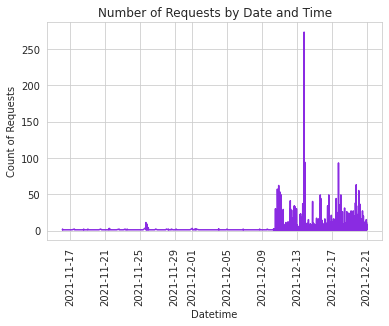


let's look at the potential class imbalance in our dataset: spikelabel
likely not spike    155883
potential spike       1526
dtype: int64


In [53]:
##Let's graph all of the data to see a high-level overview
sns.lineplot(x=log.timestamp, y=log.minute_count, color = 'blueviolet')
plt.xlabel("Datetime")
plt.ylabel('Count of Requests')
plt.title('Number of Requests by Date and Time')
plt.xticks(rotation = 90)
plt.show()

print("")
print("let's look at the potential class imbalance in our dataset:",
    log.groupby('spikelabel').size())


From the above linegraph as well as pivot table below, it is clear that around 2021-12-10, there begins to be significantly more requests. 

In [54]:
datesumdf = pd.DataFrame(log.groupby('strdate').sum()).reset_index()
datesumdf

,strdate,minute_count,spikeflag
0,2021-11-16,11,0
1,2021-11-17,14,0
2,2021-11-18,26,0
3,2021-11-19,22,0
4,2021-11-20,6,0
5,2021-11-21,14,0
6,2021-11-22,9,0
7,2021-11-23,23,0
8,2021-11-24,2,0
9,2021-11-25,58,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


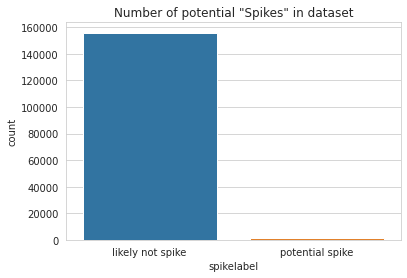

In [30]:
ax = sns.countplot(log['spikelabel'])
plt.title('Number of potential "Spikes" in dataset')
plt.show()

From the barchart above, it is clear that those instances where the minute_count is greater than our threshold is rare.

In [31]:
##Let's find the max count of requests and understand some more about that time
maxcount = max(log['minute_count'])
maxlog = log[log['minute_count'] == maxcount]
maxlog.reset_index(inplace = True, drop = True)
maxdate = list(maxlog['strdate'])
maxcountdf = log[log['strdate'].isin(maxdate)]  ##new dataframe for only the day where the max count exists
print("Max Requests in one minute:", maxcount, "occured on", max(maxdate))

Max Requests: 273 occured on 2021-12-13


In the above code chunk, I decided to hone in on the instance in the dataset where there is the most significant spike. 

Next, I decided to plot the minute_count during the entirety of this day by hour, thus we are able to more closely understand what is happening on this day. 

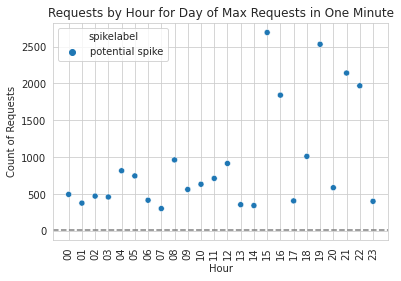

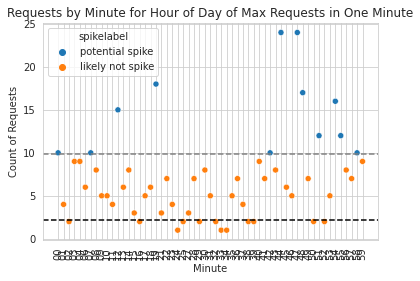

In [92]:
##Plot just that day
groupedmaxcountdf = pd.DataFrame(maxcountdf.groupby('hour').sum()).reset_index()
groupedmaxcountdf.drop('spikeflag', axis = 1, inplace = True)
groupedmaxcountdf['spikelabel'] = np.where(groupedmaxcountdf['minute_count'] > threshold, 'potential spike', 'likely not spike')

sns.scatterplot(x=groupedmaxcountdf.hour, y=groupedmaxcountdf.minute_count, hue = groupedmaxcountdf.spikelabel)
plt.axhline(meancount+stdcount*3, linestyle ='--', color = 'grey', label = 'Three Std From Mean')
plt.xticks(rotation = 90)
plt.xlabel("Hour")
plt.ylabel('Count of Requests')
plt.title('Requests by Hour for Day of Max Requests in One Minute')
plt.show()


maxhour = max(maxcountdf['hour'])
maxhourdf = log[log['hour']==maxhour] 
maxhourdf = maxhourdf[maxhourdf['strdate'].isin(maxdate)] 
maxhourdf = pd.DataFrame(maxhourdf.groupby('minute').sum()).reset_index()
maxhourdf.drop('spikeflag', axis = 1, inplace = True)
maxhourdf['spikelabel'] = np.where(maxhourdf['minute_count'] > threshold, 'potential spike', 'likely not spike')


sns.scatterplot(x=maxhourdf.minute, y=maxhourdf.minute_count, hue = maxhourdf.spikelabel)
plt.axhline(meancount+stdcount*3, linestyle ='--', color = 'grey', label = 'Three Std From Mean')
plt.axhline(meancount, linestyle ='--', color = 'black', label = 'Three Std From Mean')

plt.xticks(rotation = 90)
plt.xlabel("Minute")
plt.ylabel('Count of Requests')
plt.title('Requests by Minute for Hour of Day of Max Requests in One Minute')
plt.show()


Max potential spikes in one day: 386 occured on 2021-12-19


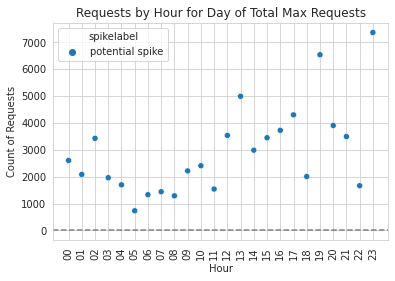

In [97]:
maxtotalspike = max(datesumdf['spikeflag'])
maxtotaldate = datesumdf[datesumdf['spikeflag']== maxtotalspike]['strdate']
maxtotaldf = log[log['strdate'].isin(maxtotaldate)] 
maxtotaldf = pd.DataFrame(maxtotaldf.groupby('hour').sum()).reset_index()
maxtotaldf['spikelabel'] = np.where(maxtotaldf['minute_count'] > threshold, 'potential spike', 'likely not spike')

print("Max potential spikes in one day:", maxtotalspike, "occured on", max(maxtotaldate))

sns.scatterplot(x=maxtotaldf.hour, y=maxtotaldf.minute_count, hue = maxtotaldf.spikelabel)
plt.axhline(meancount+stdcount*3, linestyle ='--', color = 'grey', label = 'Three Std From Mean')
plt.xticks(rotation = 90)
plt.xlabel("Hour")
plt.ylabel('Count of Requests')
plt.title('Requests by Hour for Day of Total Max Requests')
plt.show()



In [96]:
maxtotaldate

33    2021-12-19
Name: strdate, dtype: object